In [24]:
import subprocess
import sys
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import signal
from typing import Tuple, Iterator
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
from bids import BIDSLayout
from util.io.iter_BIDSPaths import *
from util.io.bids import DataSink
from mne.time_frequency import stft

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore

In [22]:
BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'
DERIV_ROOT = '../data/bids/derivatives'
FS = 5000
SUB = '9'
TASK = 'pitch'
RUN = '1'
# WSIZE = 200

In [4]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
fpaths = layout.get(scope = 'preprocessing',
                    res = 'hi',
                    suffix='epo',
                    extension = 'fif.gz',
                    return_type = 'filename')

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [ ]:
# epochs = mne.read_epochs(fpaths[9])
# events = epochs.events
# epochs = epochs.get_data()
for fpath in fpaths:
    try: 
        mne.read_epochs(fpath, preload = False)
    except FileNotFoundError:
        print(fpath)

Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-pitch_run-1_desc-clean_5khz_epo.fif-1.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
4553 matching events found
No baseline correction applied
0 projection items activated
Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-3/sub-3_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
2332 matching events found
No baseline correction applied
0 projection it

In [7]:
event_items = ['50', '100', '150', '200', '250']
condition_freqs = [50, 100, 150, 200, 250]
n_freqs = len(condition_freqs)
n_epochs = np.shape(epochs)[0]
n_chans = np.shape(epochs)[1]

### Sample spectrogram for one trial for one channel

In [8]:
epochs_100hz = epochs.get_data(item = '100')
x = epochs_100hz[1, 0]

f, t, coefs = signal.stft(x, FS)

# Trim to frequencies < 300 Hz
i = int(np.argwhere(f < 300)[-1])
f = f[0:i]
coefs = coefs[0:i,]
coefs = np.abs(coefs)

# Plot
plt.pcolormesh(t, f, coefs, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'get_data'

### Compute power

In [13]:
def summarize_stft(f, Zxx, condition_freqs): # approximate power at the condition freqs
    Zxx_condensed = np.empty([n_epochs, len(condition_freqs), 19])
    
    for i in range(len(condition_freqs)):
        
        # find indexes of freqs surrounding the condition freq
        freq = condition_freqs[i]
        a = int(np.argwhere(f < freq)[-1])
        b = a+1
        
        # subset power for the condition freq
        condition_Zxx = Zxx[:,a:b+1, :]
        
        # take average to get approximate for power at condition freq
        condition_Zxx = np.mean(condition_Zxx, axis = 1)
        Zxx_condensed[:, i, :] = condition_Zxx
    
    return Zxx_condensed

def get_stft_for_one_channel(x, fs, condition_freqs): # where x is n_epochs, n_windows
    f, t, Zxx = signal.stft(x, fs) 

    # Take real values
    Zxx = np.abs(Zxx)
    
    # Summarize to frequencies of interest
    Zxx = summarize_stft(f, Zxx, condition_freqs)
    
    return (f, t, Zxx)

In [14]:
# Run across all channels
Zxxs = np.empty([n_epochs, n_chans, n_freqs, 19]) # n_epochs, n_chans, n_freqs, n_windows
for chan in range(n_chans):
    x = pd.DataFrame(epochs[:, chan, :])
    f, t, Zxx = get_stft_for_one_channel(x, FS, condition_freqs)
    Zxxs[:, chan, :, :] = Zxx

# Reshape for decoder
Zxxs = Zxxs.reshape((n_epochs, n_freqs*n_chans, 19))

In [25]:
# Save powers
sink = DataSink(DERIV_ROOT, 'decoding')
stft_fpath = sink.get_path(
    subject = SUB,
    task = TASK,
    run = RUN,
    desc = 'stft',
    suffix = 'power',
    extension = 'npy',
)
print('Saving scores to: ' + stft_fpath)
np.save(stft_fpath, Zxxs)

Saving scores to: ../data/bids/derivatives/decoding/sub-9/sub-9_task-pitch_run-1_desc-stft_power.npy


### Decoder

---------- Decode ----------
Creating sliding estimators
Fit estimators


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
100%|██████████| Fitting SlidingEstimator : 19/19 [00:18<00:00,    1.03it/s]
100%|██████████| Fitting SlidingEstimator : 19/19 [00:20<00:00,    1.10s/it]
100%|██████████| Fitting SlidingEstimator : 19/19 [00:21<00:00,    1.13s/it]
[Parallel(n_jobs=56)]: Done   2 out of   5 | elapsed:   22.9s remaining:   34.3s
100%|██████████| Fitting SlidingEstimator : 19/19 [00:20<00:00,    1.08s/it]
100%|██████████| Fitting SlidingEstimator : 19/19 [00:21<00:00,    1.13s/it]
[Parallel(n_jobs=56)]: Done   5 out of   5 | elapsed:   23.8s finished


---------- Plot ----------
Saving figure to: ../figs/subj-9_task-pitch_run-1_stft.png


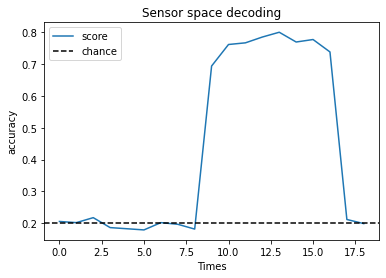

In [20]:
X = Zxxs

# Create target array
labels = pd.Series(events[:, 2])
y = labels.replace({10001 : 0, 10002 : 1, 10003 : 2, 10004 : 3, 10005 : 4})
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# Decode
print("---------- Decode ----------")
n_stimuli = 5
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
scores = cross_val_multiscore(
    time_decod,
    X, # a trials x features x time array
    y, # an (n_trials,) array of integer condition labels
    cv = 5, # use stratified 5-fold cross-validation
    n_jobs = -1, # use all available CPU cores
)
scores = np.mean(scores, axis = 0) # average across cv splits

# Save decoder score_shape
print("---------- Save decoder scores ----------")
sink = DataSink(DERIV_ROOT, 'decoding')
scores_fpath = sink.get_path(
    subject = sub,
    task = task,
    run = run,
    desc = 'stft',
    suffix = 'scores',
    extension = 'npy',
)
print('Saving scores to: ' + scores_fpath)
np.save(scores_fpath, scores)

# Plot
print("---------- Plot ----------")
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

# Save plot
fig_fpath = FIGS_ROOT + '/subj-' + SUB + '_' + 'task-pitch_' + 'run-' + RUN + '_stft' + '.png'
print('Saving figure to: ' + fig_fpath)
plt.savefig(fig_fpath)